In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

### In this project we build models to predict total trading volume in minutes <span style='color:red'>2 through 15</span>, as a function of the trading volume observed in minute <span style='color:red'>1</span>.
#### We will use half of the data to train the models, and test using the other half.
#### More precisely, we will build the model using the <span style='color:red'>even</span> numbered days, and test on the <span style='color:red'>odd</span> numbered days.

#### In order to do this, we will rely on the idea of <span style='color:red'>buckets</span> (i.e., intervals).  We first describe this idea in the context of the trading volume in the first minute.  

#### Let $\alpha$ be the average of the trading volume on minute 1 of the training data, and let $\delta$ be the standard deviation of that statistic (trading volume on minute 1 of the training data).  Then we split the interval $[\alpha - \delta, \alpha + \delta)$ into $N$ buckets, where $N$ is an integer to be decided later.  In addition, we will have two other buckets: $[0, \alpha - \delta)$  and $[\alpha + \delta, +\infty)$. 

#### Example:

In [18]:
alpha = 1e5
delta = 8e4
N = 5
print('bucket 0:  [0,',alpha-delta,')')
spread = (2*delta)/N
left = alpha - delta
for i in range(N):
    print('bucket',i+1,': [',left,',',left + spread,')')
    left = left + spread
print('bucket',N+1, ': [',alpha+delta,', infinity)')

bucket 0:  [0, 20000.0 )
bucket 1 : [ 20000.0 , 52000.0 )
bucket 2 : [ 52000.0 , 84000.0 )
bucket 3 : [ 84000.0 , 116000.0 )
bucket 4 : [ 116000.0 , 148000.0 )
bucket 5 : [ 148000.0 , 180000.0 )
bucket 6 : [ 180000.0 , infinity)


#### We will henceforth use $B_1$ to refer to the following statistic: the  bucket containing the trading volume on minute 1.

#### Likewise, we construct M+2 buckets to classify the quantity we want to predict: the trading volume in minutes 2 through 15.  Here, again, the parameter M will be tuned below.  We will use $B_{2,15}$ to refer to the bucket holding the trading volume on minutes 2 through 15.

### <span style='color:red'>Summary:</span>
#### The way we predict is as follows: we <span style='color:red'>observe</span> the bucket occupied by the trading volume on minute 1, and then based on this single observation, we use our model to <span style='color:red'>predict</span> the bucket containing the trading volume on minutes 2 through 15.  
#### Next we describe the methodology used to construct the predictive model.

#### This is based on the concept of the <span style='color:red'>empirical distribution</span>.  See, e.g.,  https://en.wikipedia.org/wiki/Empirical_distribution_function. 
#### Borrowing from this source, given $n$ samples $(X_1, X_2, \ldots, X_n)$ of a random variable, the empirical CDF (cumulative density function) is defined by:
$$ F(t) \ = \ \frac{\text{number of $X_i$ that are $\le t$}}{n}$$
#### Note that if $X$ is an integer-valued random variable, it is easy to compute the average and standard deviation of the empirical distribution. 
    

#### We will use the empirical distribution as follows.  For each value $i = 0, 1, 2, \ldots, N, N+1$ we will use the training data to build the empirical distribution of $B_{2,15}$ given that $B_{1} = i$.  In other words, we will build an empirical distribution approximation for
$$ P(B_{2,15} | B_1 = i), \quad \text{for} \ i = 0, 1, \ldots, N+1$$

### Thus we are building a total of $N+2$ empirical distributions.

#### We use this set of distributions as follows.  Consider any day of the testing data.  Suppose that on that day it happens that $B_1 = i$.  Then we predict that $B_{2,15}$ will lie in the bucket given by $E(B_{2,15} | B_1 = i)$ (the expectation could be fractional, but assume it was rounded to the nearest integer).

#### If $\hat B_{2,15}$ is the actual bucket occupied by $B_{2,15}$, the <span style='color:red'><b>error</b></span>  incurred by the prediction is the quantity 
$$ ( \hat B_{2,15} - E(B_{2,15} | B_1 = i))^2$$

### Task 1: plot the error for each day in the testing data.  Do this for multiple values of $N$ and $M$.
### Task 2.  Enumerate all values of $N$ and $M$ between $5$ and $10$ to pick a combination that minimizes the sum of errors over TSLA and NFLX (error for TSLA plus error for NFLX).
### Note: we will test your winning combination using a different asset.

In [1]:
import csv
import sys
import numpy as np
import math
import matplotlib.pyplot as plt

## Task 1

In [5]:
def read_data(filename):
    # Read the file
    f = open(filename,'r')
    csvf = csv.reader(f)
    data = list(csvf)
    f.close()

    # checking the data
    data = np.array(data)
    string_volume = data[4:,6]
    length_checker = np.vectorize(len)  
    v_len = length_checker(string_volume)
    first0 = np.argmin(v_len)

    # check how many days are in data
    data = data[4:first0,(0,6)] 
    data[0,0] = data[1,0]
    
    # computing the date
    a = data[:,0]
    a = np.array([x.split(' ') for x in a], dtype=str)
    a = a[:,0]
    y = np.array([x.split('/') for x in a], dtype=str)
    y = y[:,2].astype(int)*10000+y[:,0].astype(int)*100+y[:,1].astype(int)
    data = np.insert(data, 2, y, axis=1)

    return data

def split_data(data):
    # take half of the days as traning
    days = np.unique(data[:,2],)
    days_train = days[:len(days)//2]
    days_test  = days[len(days)//2:]
    data_train = data[np.isin(data[:,2],days_train),:]
    data_test  = data[np.isin(data[:,2],days_test),:]

    return data_train,data_test

def split_data_even_odd(data): #this splits the data into even and odd times
    train = data[::2,]
    test = data[1::2,]
    return train, test

def split_data_even_odd2(data): #this splits the data into even odd days
    a = np.frompyfunc(lambda x:x[-2:],1,1)(data[:,2])
    b = (a.astype(int)%2).astype(bool)
    train = data[np.logical_not(b),:]
    test = data[b,:] 
    return train, test

def comp_values(data):
    days = np.unique(data[:,2],)  #numberate for unique days
    values = np.zeros((len(days),2))
    for i in range(len(days)):
        day = data[np.isin(data[:,2],days[i]),:] #takes all volumes with same numberate for day i
        values[i,0] = day[0,1]
        values[i,1] = sum(day[1:15,1].astype(int)) 
    return values


def buckets_parameters(array,z):
    alpha = np.mean(array)
    delta = np.std(array)
    spread = (2*delta)/z

    limits =  np.zeros(1)
    
    lim_ini = alpha-delta 
    for i in range(z):
        if lim_ini>0:
            limits = np.append(limits,lim_ini)
        lim_ini += spread
    limits = np.append(limits,1e20)

    return limits

def comp_buckets(values, P, col,limits):
    d = len(values[:,col])
    
    l = len(limits)
    buckets = np.zeros(d)
    for i in range(d):
        for j in range(1,l):
            if values[i,col] > limits[j]: buckets[i] = j
    return buckets

def comp_conditional_prob(buckets1,buckets2):
    conditional_prob = {key: None for key in np.unique(buckets1)}
    for key in conditional_prob:
        sum_ = 0
        counter = 0
        for i in range(len(buckets1)):
            if buckets1[i] == key: 
                sum_ += buckets2[i]
                counter += 1
        conditional_prob[key] = sum_/counter
    return conditional_prob

def model_values_test(conditional_prob: dict, test_data):
    model_values = np.zeros(len(test_data))
    for i in range(len(test_data)):
        #return the conditional expected value
        #predict it stays in same bucket when no previous data.
        model_values[i] = np.around((conditional_prob.get(test_data[i,2],test_data[i,2])).astype(float))
    return model_values

def compute_error(modeled,test_data):
    error = np.zeros(len(modeled))
    for i in range(len(modeled)):
        error[i] = (modeled[i]-test_data[i,3])**2
    return error

def train_model(data_train,data_test,N,M):
    values_train = comp_values(data_train)
    N_limits = buckets_parameters(values_train,N)
    M_limits = buckets_parameters(values_train,M)
    buckets_N=comp_buckets(values_train, N, 0,N_limits)
    buckets_M=comp_buckets(values_train, M, 1,M_limits)
    values_train = np.insert(values_train, 2, buckets_N, axis=1)
    values_train = np.insert(values_train, 3, buckets_M, axis=1)
    conditional_prob = comp_conditional_prob(values_train[:,2],values_train[:,3])
        
    values_test = comp_values(data_test)
    buckets_N=comp_buckets(values_test, N, 0,N_limits)
    buckets_M=comp_buckets(values_test, M, 1,M_limits)
    values_test = np.insert(values_test, 2, buckets_N, axis=1)
    values_test = np.insert(values_test, 3, buckets_M, axis=1)  
    return conditional_prob,values_test

def errors_over(N,M,data_train,data_test):
    errors = np.full((len(N),len(M)), None)

    ncounter = 0
    for n in N: #N is array of tested N's
        mcounter=0
        for m in M: #M is array of tested M's
            cond_prob,values_test = train_model(data_train,data_test,n,m)
            modeled_values = model_values_test(cond_prob, values_test)
            errors[ncounter,mcounter] = np.sum(compute_error(modeled_values,values_test))
            mcounter+=1
        ncounter+=1
    return errors

N = 5
M = 10
data = read_data('TSLA.csv')
#data_train, data_test = split_data(data)
data_train, data_test = split_data_even_odd2(data)
values_train = comp_values(data_train)

N_limits = buckets_parameters(values_train,N)
M_limits = buckets_parameters(values_train,M)
buckets_N=comp_buckets(values_train, N, 0,N_limits)
buckets_M=comp_buckets(values_train, M, 1,M_limits)

values_train = np.insert(values_train, 2, buckets_N, axis=1)
values_train = np.insert(values_train, 3, buckets_M, axis=1)
#print(values_train)

conditional_prob = comp_conditional_prob(values_train[:,2],values_train[:,3])
#print(conditional_prob)

values_test = comp_values(data_test)
buckets_N=comp_buckets(values_test, N, 0,N_limits)
buckets_M=comp_buckets(values_test, M, 1,M_limits)
values_test = np.insert(values_test, 2, buckets_N, axis=1)
values_test = np.insert(values_test, 3, buckets_M, axis=1)

modeled_values = model_values_test(conditional_prob, values_test)
errors = compute_error(modeled_values,values_test)
#print(modeled_values)
#print(values_test)
#print(errors)

Ntest = np.arange(5,16)
Mtest = np.arange(5,16)
errors = errors_over(Ntest,Mtest,data_train,data_test)
#print(errors)

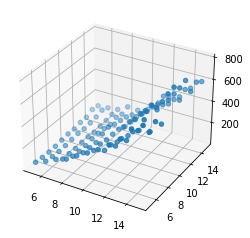

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(Ntest, Mtest)
ax.scatter(X,Y,errors.astype(int))
plt.show()

## Task 2

In [9]:
Ntest = np.arange(5,11)
Mtest = np.array([5])

NFLX_data = read_data('NFLX.csv')
TSLA_data = read_data('TSLA.csv')

NFLX_data_train, NFLX_data_test = split_data_even_odd2(NFLX_data)
TSLA_data_train, TSLA_data_test = split_data_even_odd2(TSLA_data)

NFLX_errors = errors_over(Ntest,Mtest,NFLX_data_train,NFLX_data_test)
TSLA_errors = errors_over(Ntest,Mtest,TSLA_data_train,TSLA_data_test)

print(NFLX_errors+TSLA_errors)
print("\nMinimizing N:",Ntest[np.argmin(NFLX_errors+TSLA_errors)])

[[126.0]
 [123.0]
 [120.0]
 [132.0]
 [151.0]
 [160.0]]

Minimizing N: 7


In [10]:
M = 5

NFLX_data = read_data('NFLX.csv')
NFLX_RSS = []

TSLA_data = read_data('TSLA.csv')
TSLA_RSS = []

for N in range(5,11):
    #NFLX
    NFLX_data_train, NFLX_data_test = split_data_even_odd2(NFLX_data)
    NFLX_values_train = comp_values(NFLX_data_train)
   
    NFLX_N_limits = buckets_parameters(NFLX_values_train,N)
    NFLX_M_limits = buckets_parameters(NFLX_values_train,M)
    NFLX_buckets_N=comp_buckets(NFLX_values_train, N, 0, NFLX_N_limits)
    NFLX_buckets_M=comp_buckets(NFLX_values_train, M, 1, NFLX_M_limits)

    NFLX_values_train = np.insert(NFLX_values_train, 2, NFLX_buckets_N, axis=1)
    NFLX_values_train = np.insert(NFLX_values_train, 3, NFLX_buckets_M, axis=1)

    NFLX_conditional_prob = comp_conditional_prob(NFLX_values_train[:,2],NFLX_values_train[:,3])
    NFLX_values_test = comp_values(NFLX_data_test)
    NFLX_buckets_N=comp_buckets(NFLX_values_test, N, 0, NFLX_N_limits) # There may be in issue here
    NFLX_buckets_M=comp_buckets(NFLX_values_test, M, 1, NFLX_M_limits) 
    NFLX_values_test = np.insert(NFLX_values_test, 2, NFLX_buckets_N, axis=1)
    NFLX_values_test = np.insert(NFLX_values_test, 3, NFLX_buckets_M, axis=1)

    NFLX_modeled_values = model_values_test(NFLX_conditional_prob, NFLX_values_test)
    NFLX_errors = compute_error(NFLX_modeled_values,NFLX_values_test)
    
    NFLX_RSS += [sum(NFLX_errors)]

    #TSLA

    TSLA_data_train, TSLA_data_test = split_data_even_odd2(TSLA_data)
    TSLA_values_train = comp_values(TSLA_data_train)
    TSLA_N_limits = buckets_parameters(TSLA_values_train,N)
    TSLA_M_limits = buckets_parameters(TSLA_values_train,M)
    TSLA_buckets_N=comp_buckets(TSLA_values_train, N, 0,TSLA_N_limits)
    TSLA_buckets_M=comp_buckets(TSLA_values_train, M, 1,TSLA_M_limits)

    TSLA_values_train = np.insert(TSLA_values_train, 2, TSLA_buckets_N, axis=1)
    TSLA_values_train = np.insert(TSLA_values_train, 3, TSLA_buckets_M, axis=1)

    TSLA_conditional_prob = comp_conditional_prob(TSLA_values_train[:,2],TSLA_values_train[:,3])

    TSLA_values_test = comp_values(TSLA_data_test)
    TSLA_buckets_N=comp_buckets(TSLA_values_test, N, 0,TSLA_N_limits)
    TSLA_buckets_M=comp_buckets(TSLA_values_test, M, 1,TSLA_M_limits)
    TSLA_values_test = np.insert(TSLA_values_test, 2, TSLA_buckets_N, axis=1)
    TSLA_values_test = np.insert(TSLA_values_test, 3, TSLA_buckets_M, axis=1)

    TSLA_modeled_values = model_values_test(TSLA_conditional_prob, TSLA_values_test)
    TSLA_errors = compute_error(TSLA_modeled_values,TSLA_values_test)
    
    TSLA_RSS += [sum(TSLA_errors)]

In [11]:
Total_RSS = [a + b for a, b in zip(NFLX_RSS, TSLA_RSS)]
print('Minimizing value of N: ', 5 + Total_RSS.index(min(Total_RSS)))

Minimizing value of N:  7


In [12]:
print(NFLX_RSS)
print(TSLA_RSS)
print(Total_RSS)

[69.0, 73.0, 73.0, 81.0, 92.0, 93.0]
[57.0, 50.0, 47.0, 51.0, 59.0, 67.0]
[126.0, 123.0, 120.0, 132.0, 151.0, 160.0]
